# Conditional Data Imputers

Dieses Beispiel-Notebook demonstriert die Nutzung und Performance von `GaussianImputer` und `GaussianCopulaImputer` im Kontext der conditional Imputation von Shapley Interactions und modellagnostischer Erklärungen.

Zwei Module zur conditional Imputation sind als Teil des `student_shapiq`-Pakets implementiert.

### Gaussian Imputer
Für well-behaving unimodale Daten bietet es sich an, anzunehmen, dass $x$ aus einer multivariaten Gaussian-Verteilung mit Mittelwert $µ$ und Kovarianzmatrix $Σ$ stammt.

Im vorliegenden Kontext wurde dieser Ansatz erstmals vorgeschlagen von [(Aas et al. (2021))](https://doi.org/10.1016/j.artint.2021.103502).

### Gaussian Copula Imputer
Eine Verallgemeinerung des Gaussian-Ansatzes, ebenfalls vorgeschlagen von [(Aas et al. (2021))](https://doi.org/10.1016/j.artint.2021.103502), ist die Verwendung einer Gaussian Copula. Dabei werden die Marginalverteilungen der features durch ihre empirischen Verteilungen dargestellt, während die Abhängigkeitsstruktur durch eine Gaussian-Verteilung modelliert wird.

### Import Modules


In [1]:
from __future__ import annotations

import shapiq
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import shapiq_student
from shapiq_student.gaussian import GaussianImputer
from shapiq_student.copula import GaussianCopulaImputer

print(f"shapiq version: {shapiq.__version__}")
print(f"shapiq_student version: {shapiq_student.__version__}")

shapiq version: 1.3.0
shapiq_student version: 0.4.5


Zunächst verwenden wir das California Housing Dataset zur Demonstration. Das Dataset ist verfügbar unter https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [2]:
X, y = shapiq.load_california_housing()
feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values,
    test_size=0.25,
    random_state=42,
)
n_features = X_train.shape[1]

print("Feature names:")
print(X.columns.tolist())

Feature names:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


### Trainiere ein Modell
Wir trainieren einen Random Forest Regressor auf dem California Housing Dataset, um das Modell mittels conditional Imputation zu erklären. Das Modell erreicht eine relativ gute Anpassung gemessen am $R^2$-Score.

In [3]:
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=n_features,
    max_features=2 / 3,
    max_samples=2 / 3,
    random_state=42,
)
model.fit(X_train, y_train)
print(f"Train R2: {model.score(X_train, y_train):.4f}")
print(f"Test  R2: {model.score(X_test, y_test):.4f}")

Train R2: 0.7991
Test  R2: 0.7462


### Verwendung des multivariaten Gaussian- und Gaussian Copula Imputers für Erklärungen
Sowohl der Multivariate Gaussian als auch der Gaussian Copula Imputer nutzen die gemeinsame Verteilung der features, um fehlende Werte zu schätzen – jedoch auf unterschiedliche Weise.
Der Multivariate Gaussian Imputer geht davon aus, dass alle Variablen einer gemeinsamen Gaussian-Verteilung folgen, wobei sowohl die Marginals als auch die Abhängigkeiten parametrisch modelliert werden.


##### Gausian Multivariate
Eine klassische und nützliche Eigenschaft dieser Annahme ist, dass auch die bedingten Verteilungen multivariate Gaussian-Verteilungen sind. Das heißt, wenn


$p(x) = p(x_S,x_{\overline{S}}) = \mathcal{N}_M(µ,Σ)$, wobei $µ = [µ_S,µ_{\overline{S}}]^T$ und
$$
\Sigma = \begin{bmatrix}
\Sigma_{S,S} & \Sigma_{S,\overline{S}} \\
\Sigma_{\overline{S},S} & \Sigma_{\overline{S},\overline{S}}
\end{bmatrix}
$$
dann, $p(x_\overline{S}|x_S = x^{∗}_S) = \mathcal{N}_{|\overline{S}|}(µ_{\overline{S}|S},Σ_{\overline{S}|S})$, wobei
$µ_{\overline{S}|S} = µ_{\overline{S}} + Σ_{\overline{S}S}Σ_{SS}^{-1}(x^{∗}_S − µ_S)$ und
$Σ_{\overline{S}|S} = Σ_{\overline{SS}}-Σ_{\overline{S}S}Σ_{SS}^{-1}Σ_{S\overline{S}}$. Die Parameter $µ$ und $Σ$ werden jeweils einfach mit dem Samplemittelwert und der Kovarianzmatrix der Trainingsdaten geschätzt.


Wir initialisieren den Multivariate Gaussian- oder Gaussian Copula Imputer und übergeben ihn an den Explainer. Zunächst kapseln wir die Funktion in eine Predict-Funktion, damit sie mit der shapiq-API kompatibel ist.

In [4]:
class PredictWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, X):
        return self.model.predict(X)


wrapped_model = PredictWrapper(model)

gaussian_imputer = GaussianImputer(model=wrapped_model, data=X_test)

explainer_gaussian = shapiq.TabularExplainer(
    # attributes of the explainer
    model=model,
    data=X_train,
    index="SII",
    max_order=2,

    # attributes of the imputer
    imputer=gaussian_imputer,
    sample_size=100,
)

Als Nächstes wählen wir eine Instanz aus, die erklärt werden soll.

In [5]:
x_explain_gaussian = X_test[100]
x_explain_df = pd.Series(x_explain_gaussian, index=feature_names)
print(x_explain_df)

MedInc          3.059800
HouseAge       13.000000
AveRooms        4.310056
AveBedrms       1.069832
Population    776.000000
AveOccup        2.167598
Latitude       34.040000
Longitude    -117.670000
dtype: float64


Rufe die `explain()` Funktion auf und setze `random_state` für eine reproduzierbare Approximation.

In [6]:
interaction_values_gaussian = explainer_gaussian.explain(x_explain_gaussian, budget=2**n_features, random_state=0)
print(interaction_values_gaussian)

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.0654183865546734,
    Top 10 interactions:
        (0, 4): 0.5862863824721904
        (0, 2): 0.2683290158589801
        (5,): 0.26404718360442564
        (2, 3): -0.14514186462383347
        (1, 5): -0.16933356970892624
        (1, 2): -0.2607578698977585
        (1, 4): -0.26720822000067357
        (0, 1): -0.3083362656910496
        (4,): -0.33943402756100494
        (0,): -0.36065233392643414
)


Veranschauliche die Explanation.

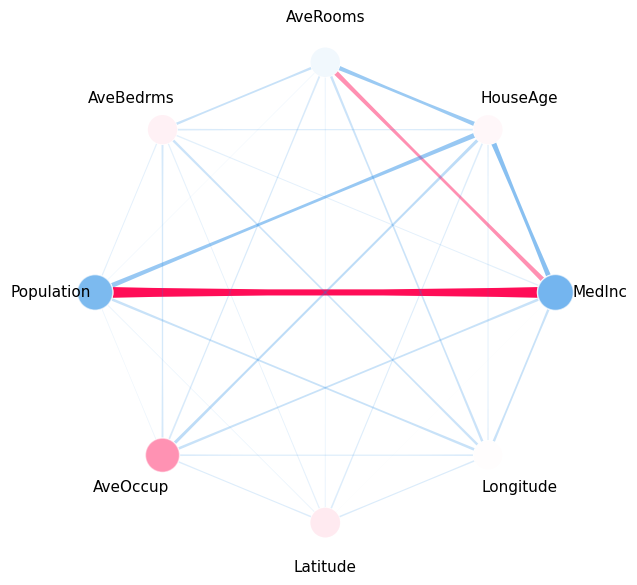

In [7]:
shapiq.network_plot(
    interaction_values=interaction_values_gaussian,
    feature_names=X.columns,
    show=True,
)

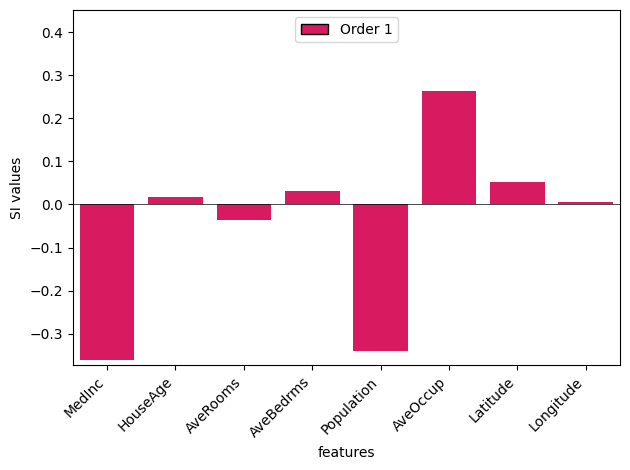

In [8]:
shapiq.stacked_bar_plot(
    interaction_values_gaussian.get_n_order(1),
    feature_names=X.columns,
    show=True,
)

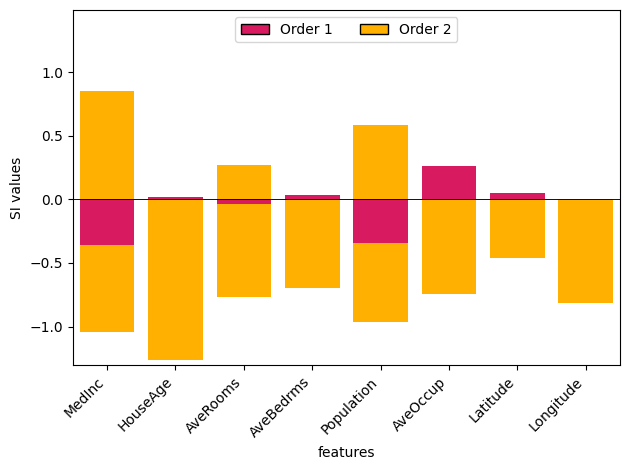

In [9]:
shapiq.stacked_bar_plot(
    interaction_values=interaction_values_gaussian,
    feature_names=X.columns,
    show=True,
)

##### Gaussian Copula
Eine Verallgemeinerung des _Gaussian_-Ansatzes besteht darin, die Marginals der features durch ihre empirischen Verteilungen zu repräsentieren und anschließend die Abhängigkeitsstruktur durch eine Gaussian-Verteilung zu modellieren. Dieser _Copula_-Ansatz erzeugt die $K$ bedingten Monte-Carlo-Samples.
$x_{\overline{S}}^{(k)} \sim  p(x_{\overline{S}}|x_S = x^{*}_{S})$ mit der folgenden Prozedur:
1. Konvertiere jede marginale Verteilung $x_j$ der Feature-Verteilung $x$ in eine normalverteilte Variable $v_j$ mittels
   $v_j = Φ^{-1}(\hat{F}(x_j))$,
   wobei $\hat{F}(x_j)$ die empirische Verteilungsfunktion von $x_j$ ist.
2. Nimm an, dass $v$ einer multivariaten Normalverteilung folgt, und sampling aus der bedingten Verteilung
   $p(v_{\overline{S}} \mid v_S = v^{∗}_S)$
   mittels der im Gaussian-Ansatz beschriebenen Methode.
3. Wandle die Marginalverteilungen $v_j$ aus der bedingten Verteilung zurück in den ursprünglichen Raum um mittels
   $\hat{x}_j = \hat{F}^{−1}_j(Φ(v_j))$.


In [10]:
class PredictWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, X):
        return self.model.predict(X)


wrapped_model = PredictWrapper(model)

gaussian_copula_imputer = GaussianCopulaImputer(model=wrapped_model, data=X_test)

explainer_copula = shapiq.TabularExplainer(
    # attributes of the explainer
    model=model,
    data=X_train,
    index="SII",
    max_order=2,

    # attributes of the imputer
    imputer=gaussian_copula_imputer,
    sample_size=100,
)

In [11]:
x_explain_copula = X_test[100]
interaction_values_copula = explainer_copula.explain(x_explain_copula, budget=2**n_features, random_state=0)
print(interaction_values_copula)

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.0654183865546734,
    Top 10 interactions:
        (0, 2): 0.7884737085054059
        (5,): 0.36069420742112607
        (1,): -0.10597534903944493
        (0, 5): -0.1146493779594047
        (1, 2): -0.1333480004627043
        (7,): -0.15858891564937233
        (6, 7): -0.17065178017924243
        (1, 5): -0.21204539553947788
        (2,): -0.2491285936342
        (0,): -0.34139673483021343
)


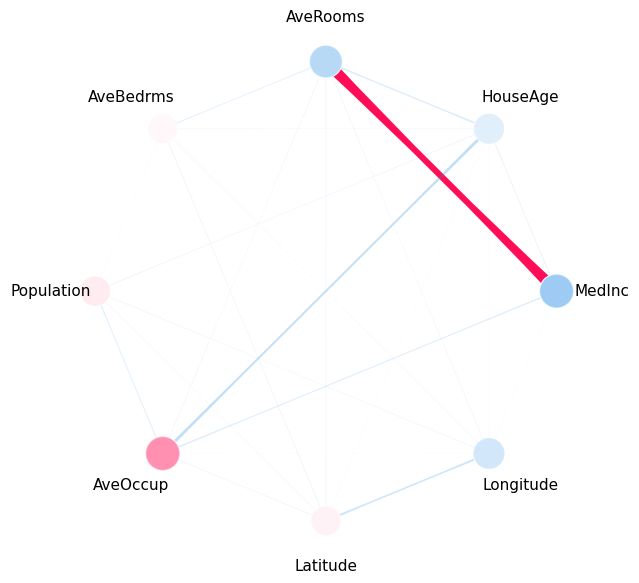

In [12]:
shapiq.network_plot(
    interaction_values=interaction_values_copula,
    feature_names=X.columns,
    show=True,
)

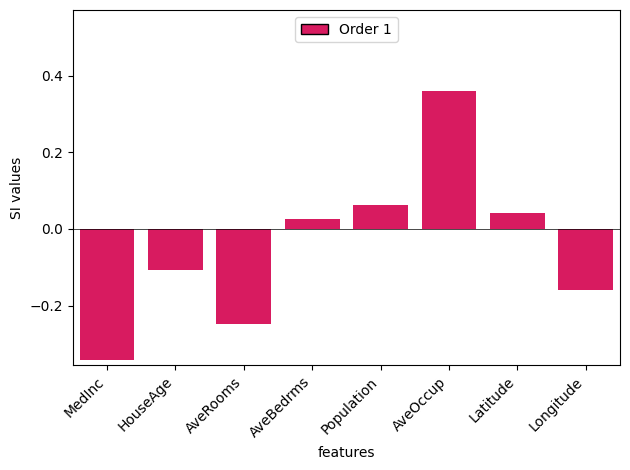

In [13]:
shapiq.stacked_bar_plot(
    interaction_values_copula.get_n_order(1),
    feature_names=X.columns,
    show=True,
)

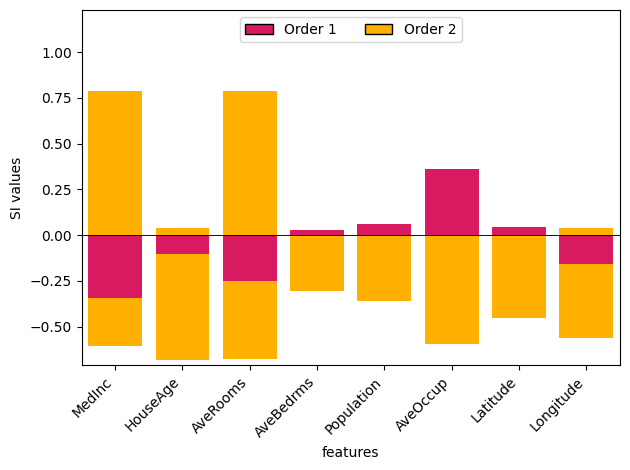

In [14]:
shapiq.stacked_bar_plot(
    interaction_values=interaction_values_copula,
    feature_names=X.columns,
    show=True,
)

Lassen Sie uns die globalen Erklärungen von `GaussianImputer` und `GaussianCopulaImputer` mithilfe eines Balkendiagramms darstellen, um ein besseres Verständnis ihrer Leistungsfähigkeit zu erhalten.

In [15]:
from tqdm.asyncio import tqdm

explanations_gaussian = []
for instance_id in tqdm(range(20)):
    x_explain_gaussian = X_test[instance_id]
    si = explainer_gaussian.explain(x=x_explain_gaussian, budget=2**n_features, random_state=0)
    explanations_gaussian.append(si)

100%|██████████| 20/20 [00:01<00:00, 12.56it/s]


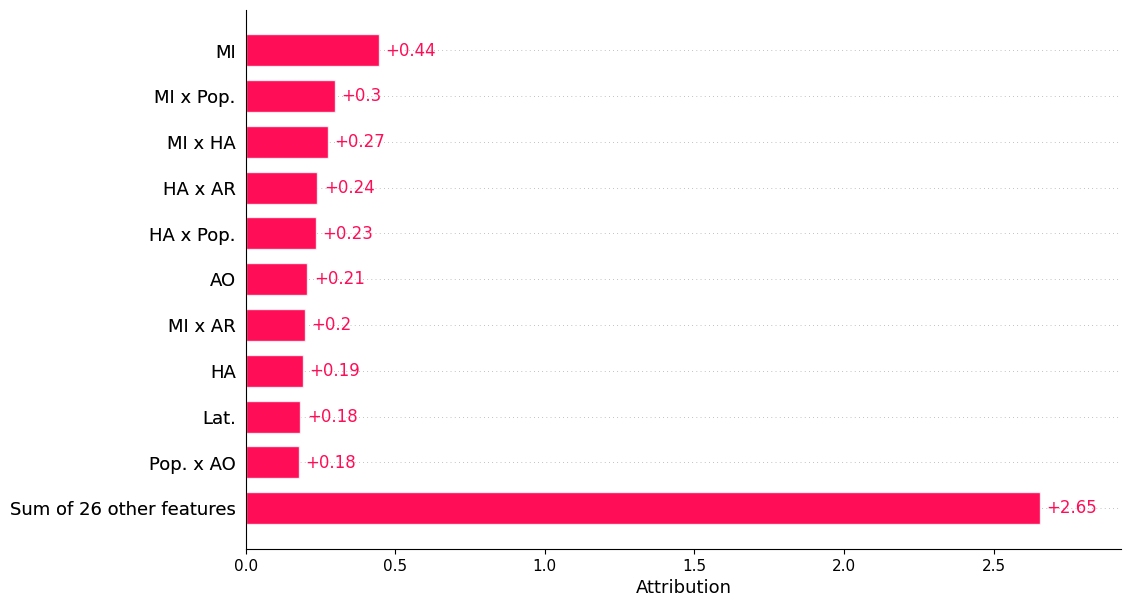

In [16]:
shapiq.plot.bar_plot(explanations_gaussian, feature_names=feature_names, show=True)

In [17]:
explanations_copula = []
for instance_id in tqdm(range(20)):
    x_explain_copula = X_test[instance_id]
    si = explainer_copula.explain(x=x_explain_copula, budget=2**n_features, random_state=0)
    explanations_copula.append(si)

100%|██████████| 20/20 [00:02<00:00,  6.84it/s]


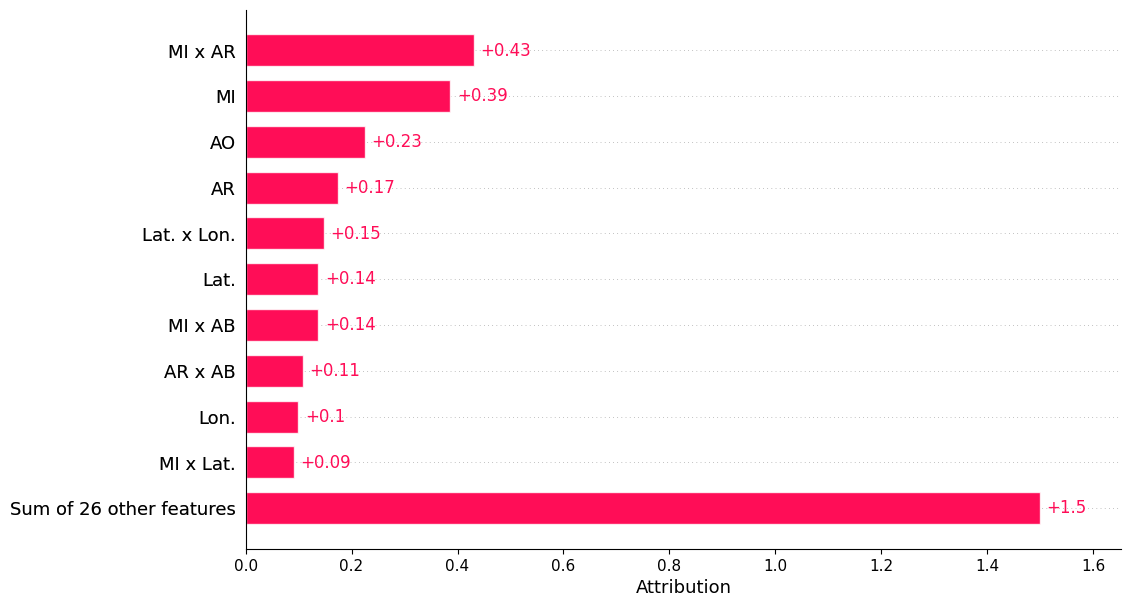

In [18]:
shapiq.plot.bar_plot(explanations_copula, feature_names=feature_names, show=True)

### Analyse
Ein zentraler Vorteil des `GaussianCopulaImputer` ergibt sich aus seiner Fähigkeit, nicht-Gaussian-verteilte Randverteilungen adäquat zu modellieren. Während der `GaussianImputer` vollständig auf der Annahme basiert, dass alle Features einer multivariaten Normalverteilung folgen – was in realen Datensätzen wie dem California Housing-Datensatz selten der Fall ist.
Es gibt zwei intuitive Perspektiven, die Verbesserung durch den `GaussianCopulaImputer` zu erkennen:
1. Der `GaussianCopulaImputer` erzeugt ein klareres Netzwerkdiagramm im Vergleich zum `GaussianImputer`, was auf eine bessere Erfassung der Feature-Interaktionen hindeutet. Diese Verbesserung zeigt sich ebenfalls im Balkendiagramm der globalen Erklärungen, wo positiv beitragende Features beim `GaussianCopulaImputer` kohärenter gruppiert erscheinen.
2. Im Balkendiagramm der globalen Erklärungen zeigt der `GaussianImputer` eine positive Interaktion zwischen `HouseAge` und `AveRooms`, die vermutlich nicht realistisch ist. Diese Interaktion verschwindet beim Einsatz des `GaussianCopulaImputer`, was auf eine zuverlässigere Darstellung der zugrunde liegenden Zusammenhänge schließen lässt.